In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import glob
from scipy.interpolate import CubicSpline
import MDAnalysis as mda
import os
import pandas as pd

rcParams = plt.matplotlib.rcParams



WIDTH = 1.5 * 8.3 / 2.54
DOUBLE_WIDTH = 1.5 * 17.1 / 2.54
DPI = 150
rcParams['axes.labelsize']= 14
rcParams['axes.xmargin']= 0
rcParams['axes.ymargin']= .1
rcParams['lines.markersize']= 5
rcParams['figure.dpi']= DPI
rcParams['figure.autolayout']= True
rcParams['figure.figsize']= (WIDTH, 3 * WIDTH / 4)
rcParams['figure.facecolor']= 'white'
rcParams['font.size']= 12
rcParams['grid.color']= '0'
rcParams['grid.linestyle']= '-'
rcParams['legend.edgecolor']= '1'
rcParams['legend.fontsize']= 10
rcParams['xtick.labelsize']= 12
rcParams['ytick.labelsize']= 12
rcParams['xtick.direction']= 'in'
rcParams['ytick.direction']= 'in'
rcParams['font.family']= 'serif'
rcParams['font.sans-serif']= ['Helvetica']
rcParams['text.usetex']=True
# Create color wheel
rcParams['axes.prop_cycle'] = plt.matplotlib.cycler(color=['#4063D8','#009B72','#FFB400','#D80032','#9558B2','#808080'])

/home/pjwalker/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_SCD(sequence):
    """
    Calculate the SCD for a given sequence:
    SCD = sum_(i>j) (sequence[i] * sequence[j] * sqrt(i - j))
    """
    SCD = 0
    for i in range(len(sequence)):
        for j in range(i):
            SCD += sequence[i] * sequence[j] * np.sqrt(i - j)
    return SCD

def get_kappa(seq, charge_map=None, g=5, gset=None):
    """
    kappa(seq, charge_map=None, g=5, gset=None)

    Compute κ (kappa) for a sequence `seq` given a `charge_map` that assigns each
    symbol in the sequence an integer charge in {-1, 0, +1} (or any reals; signs matter).

    By default, κ is computed for window size `g=5`. You can instead pass `gset` as a
    collection of window sizes (e.g. range(5,10)); the function will return the average κ over
    those windows.

    Returns:
    - single float if gset is None
    - average float over gset otherwise
    """
    if charge_map is None:
        charge_map = {"+": 1, "-": -1, "0": 0}

    charges = _charges_from_seq(seq, charge_map)
    N = len(charges)
    if N == 0:
        return 0.0

    # choose the set of window sizes
    if gset is None:
        gset = [g] if g <= N else [N]
    else:
        gset = [int(x) for x in gset if 1 <= int(x) <= N]
        if not gset:
            return 0.0

    # composition (counts of +, −, 0)
    npos = sum(1 for c in charges if c > 0)
    nneg = sum(1 for c in charges if c < 0)
    nzer = N - npos - nneg

    # build reference sequences with the same composition
    mixed_seq = _make_mixed_sequence(npos, nneg, nzer)
    blocky_seq = _make_blocky_sequence(npos, nneg, nzer)

    ks = []
    for gg in gset:
        delta_obs = _avg_delta(charges, gg)
        delta_mix = _avg_delta(mixed_seq, gg)
        delta_blk = _avg_delta(blocky_seq, gg)
        denom = delta_blk - delta_mix
        if abs(denom) < 1e-12:
            kg = 0.0
        else:
            kg = (delta_obs - delta_mix) / denom
            if kg < 0.0:
                kg = 0.0
            elif kg > 1.0:
                kg = 1.0
        ks.append(kg)

    return ks[0] if len(ks) == 1 else _mean(ks)


# --- helpers ---

def _charges_from_seq(seq, charge_map):
    # seq can be a string or an iterable of symbols/values
    if isinstance(seq, str):
        return [charge_map.get(c, 0) for c in seq]
    elif hasattr(seq, "__iter__"):
        charges = []
        for el in seq:
            if isinstance(el, (int, float)):
                charges.append(el)
            else:
                charges.append(charge_map.get(el, 0))
        return charges
    else:
        raise ValueError("seq must be a string or an iterable of symbols/values")


def _avg_delta(charges, g):
    N = len(charges)
    if g > N:
        return 0.0

    pos = [1 if c > 0 else 0 for c in charges]
    neg = [1 if c < 0 else 0 for c in charges]

    # prefix sums
    Ppos = [0] * N
    Pneg = [0] * N
    running = 0
    for i, v in enumerate(pos):
        running += v
        Ppos[i] = running
    running = 0
    for i, v in enumerate(neg):
        running += v
        Pneg[i] = running

    total = 0.0
    nwin = N - g + 1
    for i in range(0, nwin):
        j = i + g - 1
        npos = Ppos[j] - (Ppos[i-1] if i > 0 else 0)
        nneg = Pneg[j] - (Pneg[i-1] if i > 0 else 0)
        fpos = npos / g
        fneg = nneg / g
        total += (fpos - fneg) ** 2

    return total / nwin


def _make_mixed_sequence(npos, nneg, nzer):
    seq = []
    p, n, z = npos, nneg, nzer
    cur = +1 if p >= n else -1
    while p > 0 or n > 0:
        if cur == +1:
            if p > 0:
                seq.append(+1); p -= 1
            elif n > 0:
                seq.append(-1); n -= 1
            else:
                break
            cur = -1
        else:
            if n > 0:
                seq.append(-1); n -= 1
            elif p > 0:
                seq.append(+1); p -= 1
            else:
                break
            cur = +1

    if z > 0:
        gaps = len(seq) + 1
        pergap = z // gaps
        remz = z % gaps
        out = []
        for i in range(gaps):
            nz_here = pergap + (1 if i < remz else 0)
            if nz_here:
                out.extend([0] * nz_here)
            if i < len(seq):
                out.append(seq[i])
        return out
    else:
        return seq


def _make_blocky_sequence(npos, nneg, nzer):
    return [1] * npos + [-1] * nneg + [0] * nzer


def _mean(v):
    return sum(v) / len(v) if v else 0.0


In [3]:
seq = [
    '+++++++++++++++++++++++++-------------------------', # 1
    '+++++++++++++++++-+-+-+-+-+-+-+-+-----------------', # 17
    '+++++++++++++-+-+-+-+-+-+-+-+-+-+-+-+-------------', # 25
    '+++++-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-----', # 41
    '+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-', # 49
    '-------+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+++++++'
]

for i in range(len(seq)):
    _seq = np.array([1 if c=='+' else -1 for c in seq[i]])
    alpha = np.sum(_seq[1:]*_seq[:-1] < 1)
    print(f"Sequence {i+1}: kappa = {get_kappa(seq[i])}, SCD = {get_SCD([1 if c=='+' else -1 for c in seq[i]])}", f"alpha = {alpha/49}")

Sequence 1: kappa = 1.0, SCD = -1392.1071716151594 alpha = 0.02040816326530612
Sequence 2: kappa = 0.6406249999999997, SCD = -993.0248318299102 alpha = 0.3469387755102041
Sequence 3: kappa = 0.45312499999999944, SCD = -676.2565767273674 alpha = 0.5102040816326531
Sequence 4: kappa = 0.07812500000000003, SCD = -131.91343092900743 alpha = 0.8367346938775511
Sequence 5: kappa = 0.0, SCD = -20.654370895865732 alpha = 1.0
Sequence 6: kappa = 0.17187500000000008, SCD = -238.87005094151138 alpha = 0.7551020408163265


Text(0, 0.5, '$\\beta\\Delta F$')

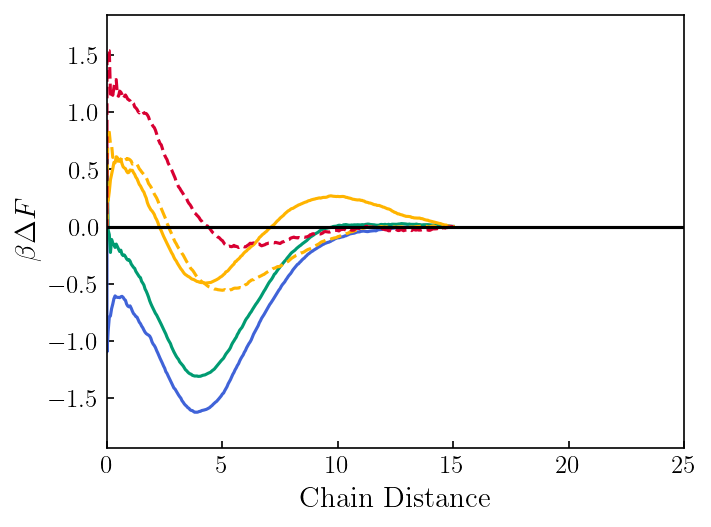

In [4]:

# Define the sequences
sequences = ['0.1ALPHA_2']
sequ = [
    [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,1,1,1,1,1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,1,1,1,1],
    [-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1]
]

salt = [0,2000]
charge = [0,2,4,8,10]
lb = [ 10, 5, 0]

B = np.zeros((len(sequences),len(charge),len(salt)))
scd = [get_SCD(seq) for seq in sequ]
color = ['C0','C1','C2','C3','C4','C5']
linestyle = ['-','--','-.',':']
# Initialize the plot
plt.clf()

# Plot data for each sequence
c1 = 0
for seq in sequences[::-1]:
    for c in charge:
        l1 = 0
        for s in salt:
            tag = f'poly_sequ_{seq}_nchain_2_znet_{c}_nsalt_{s}_temp_1_pmf'
            x = np.zeros(101*6)
            y = np.zeros(101*6)
            if os.path.exists(f'../data/{tag}/{lb[0]}/prod.pmf'):
                start = 0
                for i in range(len(lb)):
                    # print(i)
                    data = np.loadtxt(f'../data/{tag}/{lb[i]}/prod.pmf', skiprows=3)
                    x[i*101:(i+1)*101] = np.flip(data[:,0])
                    y[i*101:(i+1)*101] = np.flip(data[:,1] - data[-1,1] + start)
                    start += data[0,1] - data[-1,1]
            kappa = get_kappa(sequ[sequences.index(seq)])
            c_s = s/50**3
            Gamma = np.sqrt(8*np.pi*c_s)
            plt.plot(x,y, label=f"$\Gamma = {Gamma:.2f}$", color=color[c1], linestyle=linestyle[l1])
            # plt.plot(x,c**2/x/4, '--', alpha=0.3, color=color[5-c1])
            B[sequences.index(seq), charge.index(c), salt.index(s)] = 2*np.pi*np.sum(x**2*(np.exp(-(y-y[0])) - 1))*(x[1]-x[0])
            l1 += 1
            if l1 >= len(linestyle):
                l1 = 0
        c1 += 1
        if c1 >= len(color):
            c1 = 0


plt.plot([0,25],[0,0], 'k-')
# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\beta\Delta F$')
# plt.legend()
# plt.xlim(0,18)
# plt.ylim(-5,2)

# Show the plot
# plt.savefig('pmf.png')

In [5]:
B

array([[[-2381.89514486,     0.        ],
        [-1345.75436858,     0.        ],
        [  534.65227578,  -791.33719292],
        [    0.        ,  -273.17801927],
        [    0.        ,     0.        ]]])

IndexError: index 1 is out of bounds for axis 0 with size 1

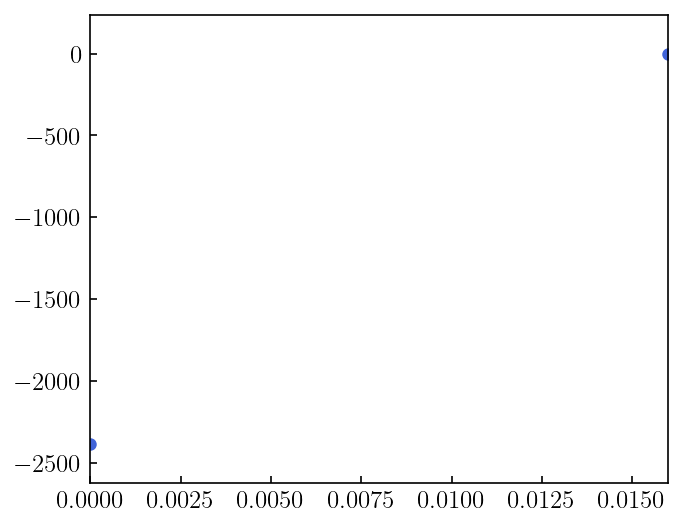

In [6]:
plt.clf()
plt.plot(np.array(salt)/50**3, B[0,0,:], 'o',
         label=f"$\kappa={scd[0]:0.3f}$")
plt.plot(np.array(salt)/50**3, B[1,0,:], 'o',
         label=f"$\kappa={scd[1]:0.3f}$")

plt.plot(np.array(salt)/50**3, B[0,1,:], 'o',
         label=f"$\kappa={scd[0]:0.3f}$")
plt.plot(np.array(salt)/50**3, B[1,1,:], 'o',
         label=f"$\kappa={scd[1]:0.3f}$")
# plt.plot(np.array(salt)/50**3, B[2,0,:], 'o',
#          label=f"$\kappa={scd[2]:0.3f}$")
# plt.plot(np.array(salt)/50**3, B[3,0,:], 'o',
#          label=f"$\kappa={scd[3]:0.3f}$")
# plt.ylim(-10,5)
# plt.xlim(0,0.02)
plt.legend()
plt.xlabel(r'$c_s$')
plt.ylabel(r'$B_2\sigma^3$')

In [7]:
files = glob.glob('../data/poly_sequ_*_pmf')
B = np.zeros(len(files))
Z_net = np.zeros(len(files))
kappa = np.zeros(len(files))
alpha = np.zeros(len(files))
c_salt = np.zeros(len(files))
name = np.array([])

lb = [10, 5, 0]

for f in files:
    # Extract parameters from filename
    parts = f.split('_')
    sequ = parts[2]
    print(sequ)
    if parts[3] != 'nchain':
        sequ += '_' + parts[3]
    name = np.append(name, sequ)
    znet = int(parts[-6])
    nsalt = int(parts[-4])
    tag = f'poly_sequ_{sequ}_nchain_2_znet_{znet}_nsalt_{nsalt}_temp_1_pmf'
    if os.path.exists(f'../data/{tag}/{lb[0]}/input.data'):
        x = np.zeros(101*6)
        y = np.zeros(101*6)
        if os.path.exists(f'../data/{tag}/{lb[0]}/prod.pmf'):
            start = 0
            for i in range(len(lb)):
                data = np.loadtxt(f'../data/{tag}/{lb[i]}/prod.pmf', skiprows=3)
                x[i*101:(i+1)*101] = np.flip(data[:,0])
                y[i*101:(i+1)*101] = np.flip(data[:,1] - data[-1,1] + start)
                start += data[0,1] - data[-1,1]
        B[files.index(f)] = 2*np.pi*np.sum(x**2*(np.exp(-(y-y[0])) - 1))*(x[1]-x[0])
        Z_net[files.index(f)] = znet
        c_salt[files.index(f)] = nsalt / 50**3
        u = mda.Universe(f'{f}/0/input.data')
        sequ = np.array([u.atoms[i].charge for i in range(50)])
        alpha[files.index(f)] = np.sum(sequ[0:-2]*sequ[1:-1] < 0) / (50 - 1)
        kappa[files.index(f)] = get_kappa(sequ)
    elif os.path.exists(f'../data/{tag}/{lb[0]}/prod.pmf'):
        print(f)

df = pd.DataFrame({
    'B2': B,
    'Z_net': Z_net,
    'c_salt': c_salt,
    'kappa': kappa,
    'alpha': alpha,
    'name': name
})

0.0ALPHA
0.2ALPHA
0.4ALPHA
0.6ALPHA
0.0ALPHA
0.2ALPHA
0.1ALPHA
0.4ALPHA
0.6ALPHA
0.2ALPHA
0.2ALPHA
0.6ALPHA
0.2ALPHA
0.0ALPHA
0.6ALPHA
0.0ALPHA
0.2ALPHA
0.5ALPHA
0.2ALPHA
0.1ALPHA
0.2ALPHA
1.0ALPHA
0.0ALPHA
0.6ALPHA
0.2ALPHA
0.0ALPHA
0.5ALPHA
0.1ALPHA
0.4ALPHA
0.2ALPHA
0.4ALPHA
0.2ALPHA
0.2ALPHA
0.6ALPHA
0.1ALPHA
0.2ALPHA
0.6ALPHA
0.0ALPHA
0.2ALPHA
0.2ALPHA
0.0ALPHA
0.0ALPHA
0.2ALPHA
0.2ALPHA
0.0ALPHA
0.4ALPHA
0.0ALPHA
0.2ALPHA
0.0ALPHA
0.1ALPHA
0.0ALPHA
0.2ALPHA
0.5ALPHA
0.0ALPHA
0.1ALPHA
0.2ALPHA
0.0ALPHA
0.4ALPHA
0.8ALPHA


In [8]:
df.sort_values(by=['name','alpha', 'kappa','Z_net', 'c_salt'], inplace=True)
df

,B2,Z_net,c_salt,kappa,alpha,name
0,-7797.678604,0.0,0.0000,1.000000,0.020408,0.0ALPHA
41,-4560.013853,0.0,0.0016,1.000000,0.020408,0.0ALPHA
46,-3459.378647,0.0,0.0080,1.000000,0.020408,0.0ALPHA
37,-2453.237516,0.0,0.0160,1.000000,0.020408,0.0ALPHA
4,-3397.330540,2.0,0.0000,1.000000,0.020408,0.0ALPHA
40,-221.572717,4.0,0.0000,1.000000,0.020408,0.0ALPHA
53,-2165.601237,4.0,0.0080,1.000000,0.020408,0.0ALPHA
13,-2005.097371,4.0,0.0160,1.000000,0.020408,0.0ALPHA
56,-1114.682795,4.0,0.0480,1.000000,0.020408,0.0ALPHA
44,-1061.153464,6.0,0.0160,1.000000,0.020408,0.0ALPHA


Text(0, 0.5, '$|Z_\\mathrm{net}|/N$')

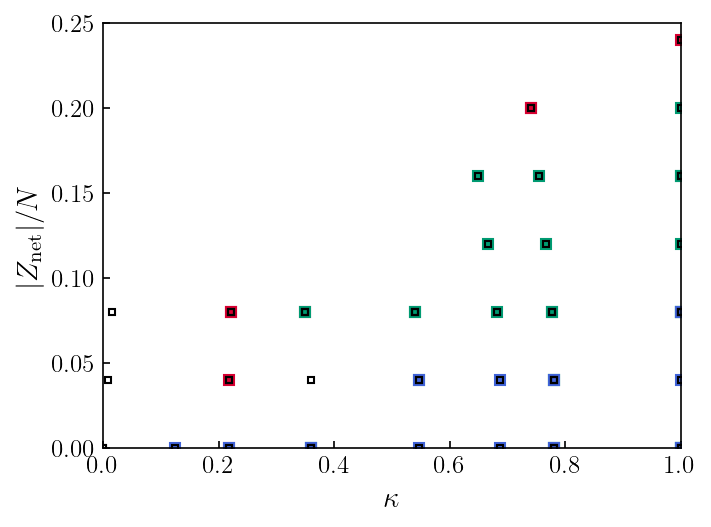

In [9]:
plt.clf()
idx_self_co = np.where((B<0) * (c_salt == 0.0))
idx_self_no = np.where((B>0) * (c_salt == 0.0))
idx_salt_co = np.where((B<0) * (c_salt > 0.0))
idx_salt_no = np.where((B>0) * (c_salt > 0.0))

kappa_self_no_salt_co = np.array([])
alpha_self_no_salt_co = np.array([])
Z_net_self_no_salt_co = np.array([])
for i in idx_salt_co[0]:
    kappa_ref = kappa[i]
    Z_net_ref = Z_net[i]

    # Check for matches in self-coacervation without salt
    for j in idx_self_no[0]:
        if np.isclose(kappa_ref, kappa[j], atol=0.05) and Z_net[j] == Z_net_ref:
            kappa_self_no_salt_co = np.append(kappa_self_no_salt_co, kappa_ref)
            alpha_self_no_salt_co = np.append(alpha_self_no_salt_co, alpha[j])
            Z_net_self_no_salt_co = np.append(Z_net_self_no_salt_co, Z_net_ref)

# x1 = np.linspace(0.0,1,100)
# y1 = 0.12*x1-0.12*0.05

# x_fit = [0.05,0.47,1.2]
# y_fit = [0.00,0.16,0.25]
# p = np.polyfit(x_fit, y_fit, 2)
# y2 = np.polyval(p,x1)
plt.plot(kappa[idx_salt_no], Z_net[idx_salt_no]/50, 's', color='C3')

plt.plot(kappa[idx_salt_co], Z_net[idx_salt_co]/50, 's', color='C1')

plt.plot(kappa[idx_self_co], Z_net[idx_self_co]/50, 's', label='Self-Coacervation Data')

# plt.fill_between(x, np.zeros(100), y, alpha=0.4,color="C0")
# plt.plot(kappa_self_no_salt_co, Z_net_self_no_salt_co/50, 's', color='C1')
# plt.fill_between(x1,y1,y2,alpha=0.4,color="C1")
plt.plot(kappa, Z_net/50, 's', color='k', markersize=3, mfc='none', label='All Data')
plt.xlim(0,1)
plt.ylim(0,0.25)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$|Z_\mathrm{net}|/N$')

In [13]:
idx_self_co

(array([ 0,  3,  4, 10, 16, 21, 31, 40, 42, 54]),)

Text(0, 0.5, '$\\beta\\Delta F$')

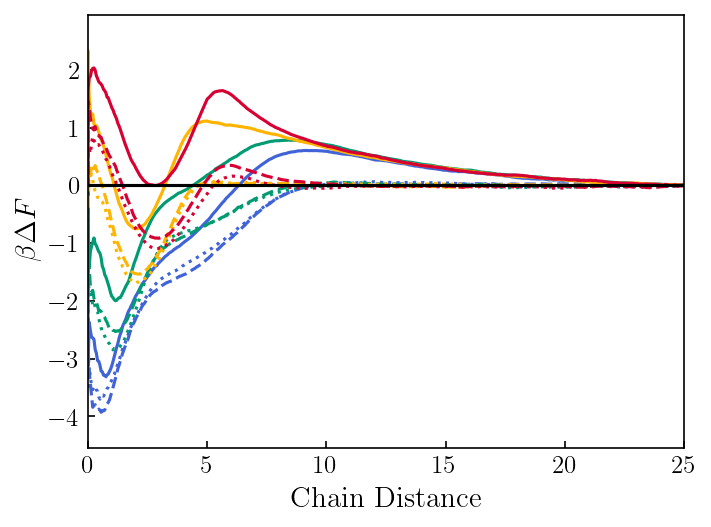

In [10]:

# Define the sequences
sequences = ['0.0ALPHA','0.2ALPHA','0.4ALPHA','0.6ALPHA']
sequ = [
    [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1]
]

salt = [0,1000,2000]
charge = [4]
lb = [20, 15, 10, 5, 0]

B = np.zeros((len(sequences),len(charge),len(salt)))
scd = [get_SCD(seq) for seq in sequ]
color = ['C0','C1','C2','C3','C4','C5']
linestyle = ['-','--',':','-.']
# Initialize the plot
plt.clf()

# Plot data for each sequence
c1 = 0
for seq in sequences:
    l1 = 0
    for c in charge:
        for s in salt:
            tag = f'poly_sequ_{seq}_nchain_2_znet_{c}_nsalt_{s}_temp_1_pmf'
            x = np.zeros(101*6)
            y = np.zeros(101*6)
            start = 0 
            for i in range(len(lb)):
                # print(i)
                data = np.loadtxt(f'../data/{tag}/{lb[i]}/prod.pmf', skiprows=3)
                x[i*101:(i+1)*101] = np.flip(data[:,0])
                y[i*101:(i+1)*101] = np.flip(data[:,1] - data[-1,1] + start)
                start += data[0,1] - data[-1,1]
            plt.plot(x,y, label=f"$\\alpha = {seq[0:3]}, |Z_\mathrm{{net}}|/N = {c/50:.2f}, s = {s/50**3:0.3f}$", color=color[c1], linestyle=linestyle[l1])
            B[sequences.index(seq), charge.index(c), salt.index(s)] = 2*np.pi*np.sum(x**2*(np.exp(-(y-y[0])) - 1))*(x[1]-x[0])
            l1 += 1
    c1 += 1
plt.plot([0,25],[0,0], 'k-')
# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\beta\Delta F$')
# plt.legend()
# plt.xlim(0,18)

# Show the plot
# plt.savefig('pmf.png')

Text(0, 0.5, '$B_2\\sigma^3$')

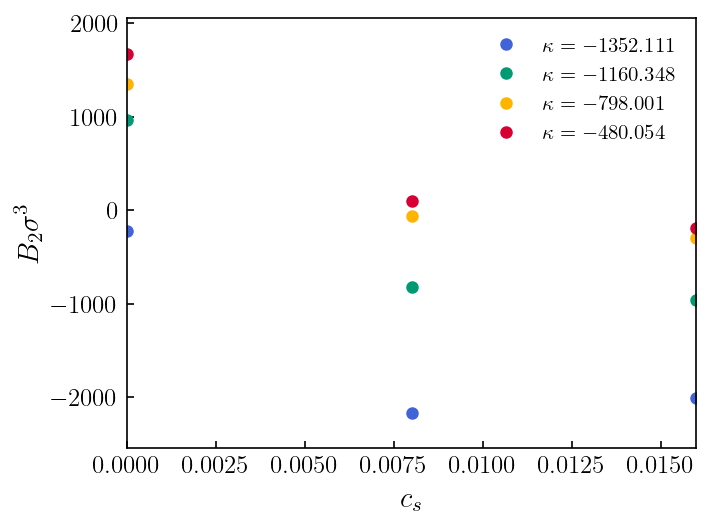

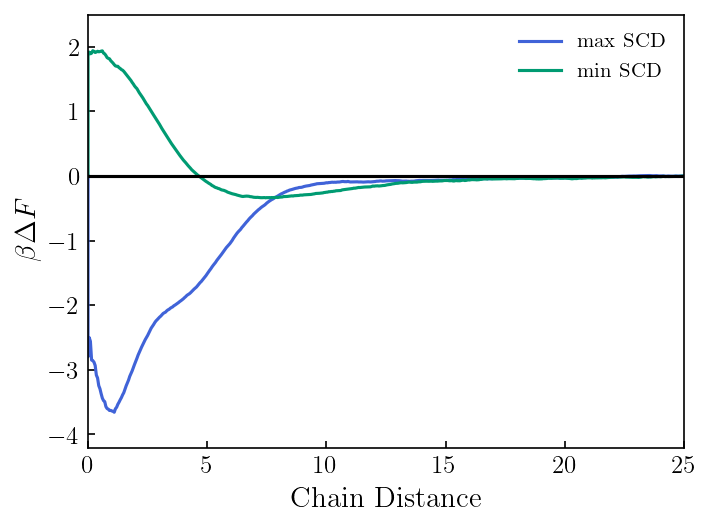

In [9]:

# Define the sequences
sequences = ['0.2ALPHA','0.2ALPHA_2']
label = ['max SCD', 'min SCD']

lb = [20, 15, 10, 5, 0]

B = np.zeros(len(sequences))

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_0_nsalt_0_temp_1_pmf'
    x = np.zeros(101*6)
    y = np.zeros(101*6)
    start = 0 
    for i in range(len(lb)):
        # print(i)
        data = np.loadtxt(f'../data/{tag}/{lb[i]}/prod.pmf', skiprows=3)
        x[i*101:(i+1)*101] = np.flip(data[:,0])
        y[i*101:(i+1)*101] = np.flip(data[:,1] - data[-1,1] + start)
        start += data[0,1] - data[-1,1]
    plt.plot(x,y, label=label[sequences.index(seq)])
    B[sequences.index(seq)] = 2*np.pi*np.sum(x**2*(np.exp(-(y-y[0])) - 1))*(x[1]-x[0])
plt.plot([0,25],[0,0], 'k-')
# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\beta\Delta F$')
plt.legend()
# plt.xlim(0,18)

# Show the plot
plt.savefig('pmf.png')

Text(0, 0.5, '$B_2\\sigma^3$')

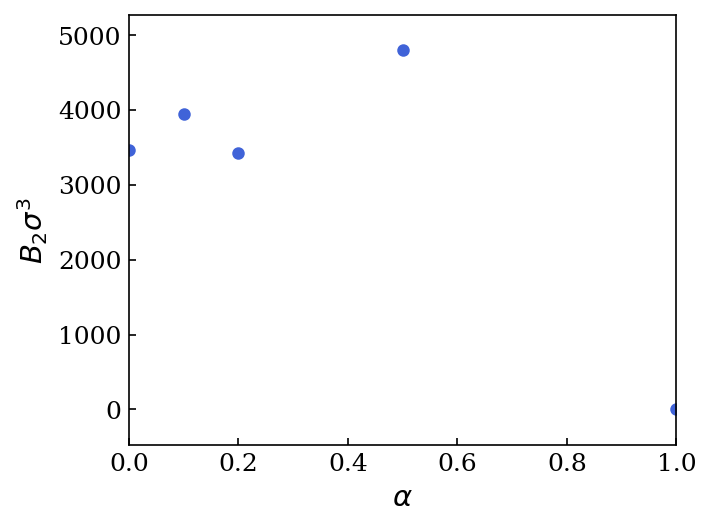

In [5]:
plt.clf()
alpha = [0.0, 0.1, 0.2, 0.5, 1.0]
plt.plot(alpha, B, 'o')
plt.xlim(0,1)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$B_2\sigma^3$')

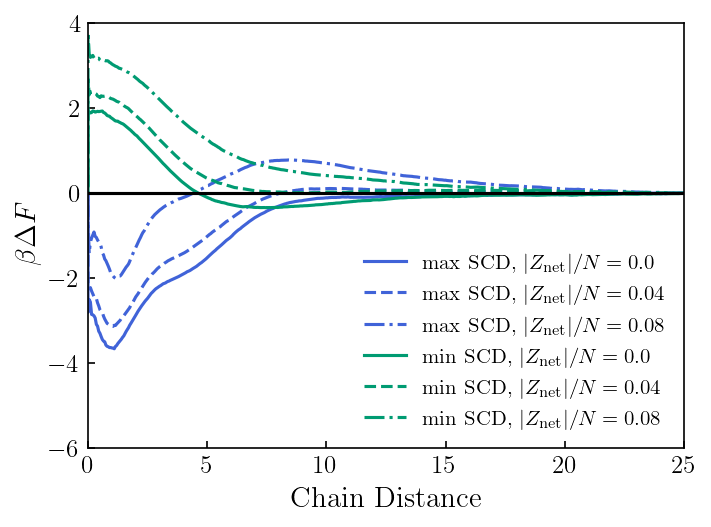

In [49]:

# Define the sequences
sequences = ['0.2ALPHA','0.2ALPHA_2']
label = ['max SCD', 'min SCD']
charge = [0, 2, 4]
color = ['C0', 'C1', 'C2', 'C3']
style = ['-', '--', '-.', ':']

B = np.zeros((len(sequences), len(charge)))

lb = [20, 15, 10, 5, 0]

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    for chrg in charge:
        tag = f'poly_sequ_{seq}_nchain_2_znet_{chrg}_nsalt_0_temp_1_pmf'
        x = np.zeros(101*6)
        y = np.zeros(101*6)
        start = 0
        for i in range(len(lb)):
            # print(i)
            data = np.loadtxt(f'../data/{tag}/{lb[i]}/prod.pmf', skiprows=3)
            x[i*101:(i+1)*101] = np.flip(data[:,0])
            y[i*101:(i+1)*101] = np.flip(data[:,1] - data[-1,1] + start)
            start += data[0,1] - data[-1,1]

        B[sequences.index(seq), charge.index(chrg)] = 2*np.pi*np.sum(x**2*(np.exp(-(y-y[-1])) - 1))*(x[1]-x[0])
        plt.plot(x,y, label=f"{label[sequences.index(seq)]}, $|Z_\\mathrm{{net}}|/N = {chrg/50}$", linestyle=style[charge.index(chrg)], color=color[sequences.index(seq)])
plt.plot([0,25],[0,0], 'k-')
# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\beta \Delta F$')
plt.legend()
plt.xlim(0,25)
plt.ylim(-6,4)

# Show the plot
plt.savefig('pmf.png')

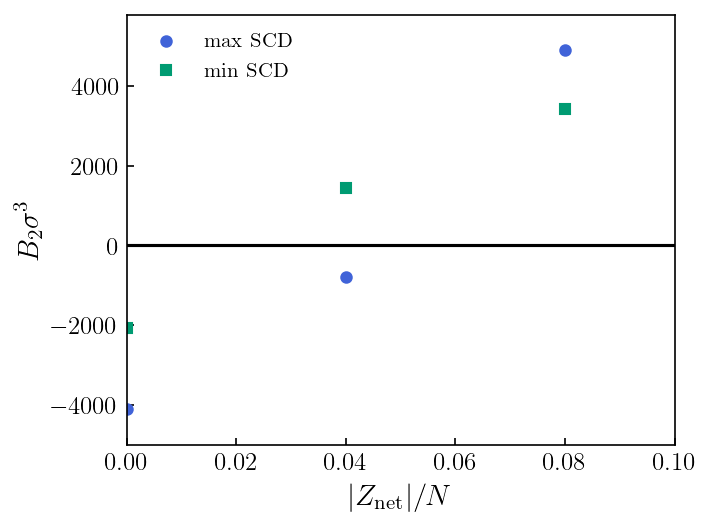

In [51]:
plt.clf()
plt.plot(np.array(charge)/50, B[0,:], 'o', label='max SCD')
plt.plot(np.array(charge)/50, B[1,:], 's', label='min SCD')
# plt.plot(np.array(charge)/50, B[2,:], 'o')
# plt.plot(np.array(charge)/50, B[3,:], 'o')
plt.plot([0,0.2],[0,0], 'k-')
plt.xlim(0,0.1)
plt.xlabel(r'$|Z_\mathrm{net}|/N$')
plt.ylabel(r'$B_2\sigma^3$')
plt.legend()

/tmp/ipykernel_266670/810940589.py:31: RuntimeWarning: divide by zero encountered in divide
  y = 3/x
/tmp/ipykernel_266670/810940589.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


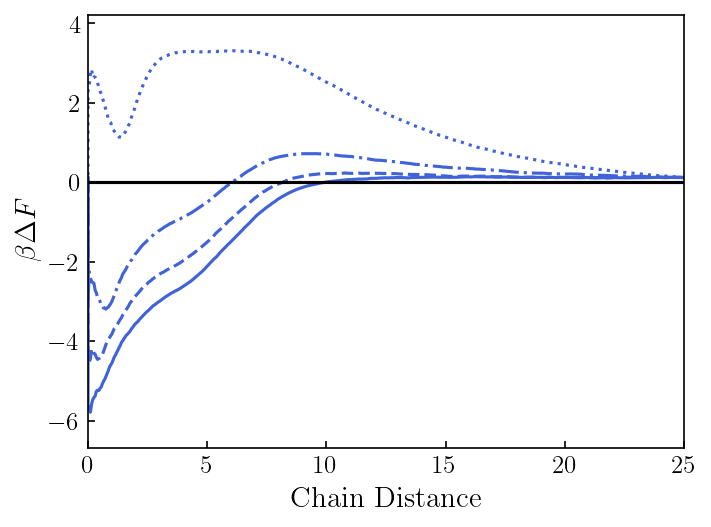

In [9]:

# Define the sequences
sequences = ['0.0ALPHA']
charge = [0,2,4,8]
color = ['C0', 'C1', 'C2', 'C3']
style = ['-', '--', '-.', ':']

B = np.zeros((len(sequences), len(charge)))

lb = [20, 15, 10, 5, 0]

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    for chrg in charge:
        tag = f'poly_sequ_{seq}_nchain_2_znet_{chrg}_nsalt_0_temp_1_pmf'
        x = np.zeros(101*6)
        y = np.zeros(101*6)
        start = 0
        for i in range(len(lb)):
            # print(i)
            data = np.loadtxt(f'../data/{tag}/{lb[i]}/prod.pmf', skiprows=3)
            x[i*101:(i+1)*101] = np.flip(data[:,0])
            y[i*101:(i+1)*101] = np.flip(data[:,1] - data[-1,1] + start)
            start += data[0,1] - data[-1,1]

        B[sequences.index(seq), charge.index(chrg)] = 2*np.pi*np.sum(x**2*(np.exp(-(y-y[-1])) - 1))*(x[1]-x[0])
        plt.plot(x,y+3/25, label="", linestyle=style[charge.index(chrg)], color=color[sequences.index(seq)])
plt.plot([0,25],[0,0], 'k-')
y = 3/x
# plt.plot(x, y, 'k-', label=r'$1/r$')
# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\beta \Delta F$')
plt.legend()
plt.xlim(0,25)
# plt.ylim(-1,1)

# Show the plot
plt.savefig('pmf.png')

In [40]:
np.sqrt(12/16)

np.float64(0.8660254037844386)

In [43]:
12/16

0.75

In [46]:
(2*0.8660254037844386)**2/4

0.7499999999999999

In [37]:
3/4

0.75

Text(0, 0.5, '$B_2\\sigma^3$')

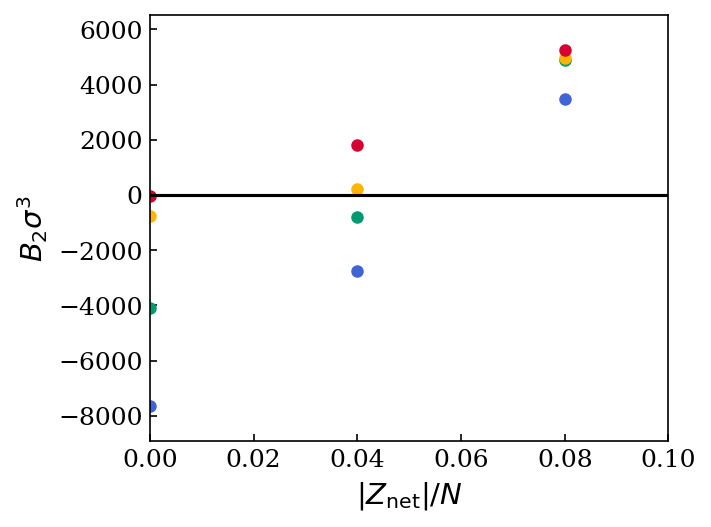

In [9]:
plt.clf()
plt.plot(np.array(charge)/50, B[0,:], 'o')
plt.plot(np.array(charge)/50, B[1,:], 'o')
plt.plot(np.array(charge)/50, B[2,:], 'o')
plt.plot(np.array(charge)/50, B[3,:], 'o')
plt.plot([0,0.2],[0,0], 'k-')
plt.xlim(0,0.1)
plt.xlabel(r'$|Z_\mathrm{net}|/N$')
plt.ylabel(r'$B_2\sigma^3$')

IndexError: index 1 is out of bounds for axis 1 with size 1

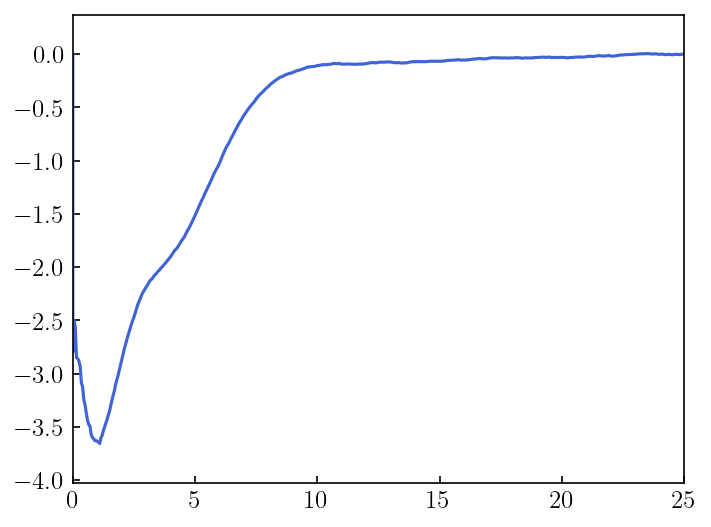

In [4]:

# Define the sequences
sequences = ['0.2ALPHA','0.2ALPHA_2']
charge = [0, 2, 4]

# B = np.zeros((len(sequences), len(charge)))

lb = [20, 15, 10, 5, 0]

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    for chrg in charge:
        tag = f'poly_sequ_{seq}_nchain_2_znet_{chrg}_nsalt_0_temp_1_pmf'
        x = np.zeros(101*6)
        y = np.zeros(101*6)
        start = 0
        for i in range(len(lb)):
            # print(i)
            data = np.loadtxt(f'../data/{tag}/{lb[i]}/prod.pmf', skiprows=3)
            x[i*101:(i+1)*101] = np.flip(data[:,0])
            y[i*101:(i+1)*101] = np.flip(data[:,1] - data[-1,1] + start)
            start += data[0,1] - data[-1,1]

        B[sequences.index(seq), charge.index(chrg),1] = 2*np.pi*np.sum(x**2*(np.exp(-(y-y[-1])) - 1))*(x[1]-x[0])
        plt.plot(x,y)# label=f"$\\alpha = {seq[0:3]}, |Z_\\mathrm{{net}}|/N = {chrg/50}$")

plt.plot([0,25],[0,0], 'k-')
# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\beta \Delta F$')
plt.legend(loc='upper right')
plt.xlim(0,25)

# Show the plot
plt.savefig('pmf.png')

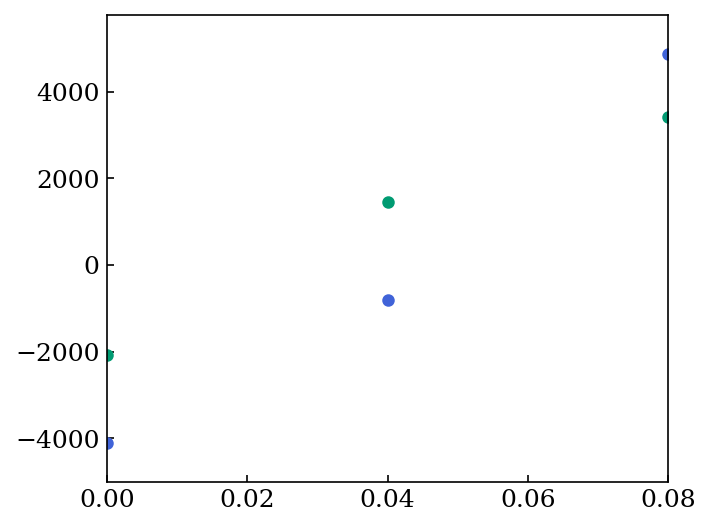

In [12]:
plt.clf()
plt.plot(np.array(charge)/50, B[0,:], 'o')
plt.plot(np.array(charge)/50, B[1,:], 'o')


In [76]:
files = glob.glob('../data/poly_sequ_*_nchain_2_*')
B = np.zeros(len(files))
blocky = np.zeros(len(files))
alpha = np.zeros(len(files))
charge = np.zeros(len(files))
SCD = np.zeros(len(files))
for i, f in enumerate(files):
    x = np.zeros(101*6)
    y = np.zeros(101*6)
    start = 0
    parts = f.split('_')
    if parts[4] == '2':
        blocky[i] = 1
    alpha[i] = float(parts[2][0:3])
    charge[i] = float(parts[-6])
    if charge[i] == 0:
        lb = [10, 5, 0]
    else:
        lb = [20, 15, 10, 5, 0]

    for j in range(len(lb)):
        # print(i)
        data = np.loadtxt(f'{f}/{lb[j]}/prod.pmf', skiprows=3)
        x[j*101:(j+1)*101] = np.flip(data[:,0])
        y[j*101:(j+1)*101] = np.flip(data[:,1] - data[-1,1] + start)
        start += data[0,1] - data[-1,1]

    B[i] = 2*np.pi*np.sum(x**2*(np.exp(-(y-y[-1])) - 1))*(x[1]-x[0])
    with open(f'{f}/0/poly_init.py', 'r') as g:
        lines = g.readlines()
        sequence = lines[38].strip().split('=')[1].strip().strip('"')[1:-1].split(',')
        sequence = [int(s) for s in sequence]
    SCD[i] = get_SCD(sequence)
nSCD = (SCD - np.min(SCD))/(np.max(SCD) - np.min(SCD))
blocky = blocky == 1

In [77]:
nSCD

array([0.85045109, 0.83065812, 0.93743482, 0.82405689, 0.11637937,
       0.41103372, 0.1686593 , 0.1397303 , 0.94373634, 0.98176071,
       0.66373358, 0.96261615, 0.97566358, 0.99805558, 0.43235249,
       0.64294173, 0.02910653, 0.00727736, 0.        , 0.40392608,
       0.88069657, 0.14696335, 1.        , 0.63600908])

In [97]:
charge

array([4., 2., 0., 0., 8., 2., 4., 0., 2., 2., 4., 4., 0., 0., 4., 2., 4.,
       2., 0., 0., 0., 2., 4., 0.])

0


Text(0, 0.5, '$B_2\\sigma^3$')

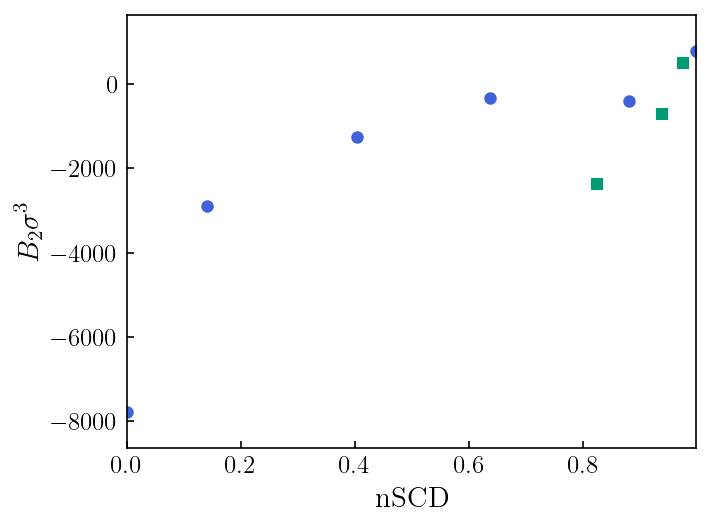

In [101]:
plt.clf()
uchrg = np.unique(charge)[0:1]
for i, chrg in enumerate(uchrg):
    # _alpha = alpha[charge == chrg]
    # _blocky = blocky[charge == chrg]
    _B1 = B[(charge == chrg) * blocky]
    _nSCD1 = nSCD[(charge == chrg) * blocky]
    print(i)

    _B2 = B[(charge == chrg) * ~blocky]
    _nSCD2 = nSCD[(charge == chrg) * ~blocky]
    plt.plot(_nSCD1, _B1, 'o', label=f'$|Z_\\mathrm{{net}}|/N$ = {chrg/50}', color=f'C{i}')
    plt.plot(_nSCD2, _B2, 's', label=f'', color=f'C{i+1}', markersize=5)
plt.xlabel('nSCD')
plt.ylabel(r'$B_2\sigma^3$')

Charge: 2.0, Alpha: [0.  0.2 0.4 0.6], B: [-2768.26788276  -801.23290279   219.92690675  1801.45018332]


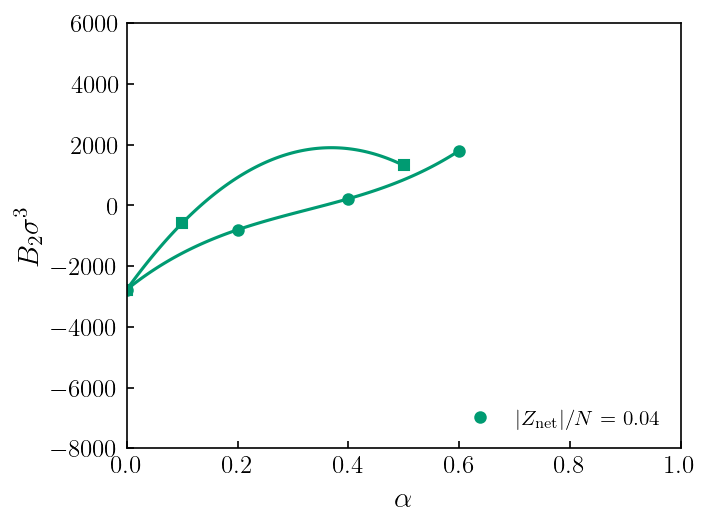

In [ ]:
plt.clf()
# Plot the non-blocky PMF
_alpha = alpha[blocky]
_B = B[blocky]
_chrg = charge[blocky]
_nSCD = nSCD[blocky]
uchrg = np.unique(_chrg)[1:2]
for i, chrg in enumerate(uchrg):
    a = np.linspace(0, np.max(_alpha[_chrg == chrg]), 100)
    sorted_indices = np.argsort(_alpha[_chrg == chrg])
    _alpha_sorted = _alpha[_chrg == chrg][sorted_indices]
    _B_sorted = _B[_chrg == chrg][sorted_indices]
    print(f'Charge: {chrg}, Alpha: {_alpha_sorted}, B: {_B_sorted}')
    # Use CubicSpline for smoother interpolation
    p = CubicSpline(_alpha_sorted, _B_sorted)
    plt.plot(a, p(a), label='', color=f'C{i+1}')
    plt.plot(_alpha[_chrg == chrg], _B[_chrg == chrg], 'o', label=f'$|Z_\mathrm{{net}}|/N$ = {chrg/50}', color=f'C{i+1}')

# Reset color wheel
plt.gca().set_prop_cycle(None)

# Plot the blocky PMF as squares
blocky_2 = ~blocky
blocky_2[alpha == 1.0] = True
blocky_2[alpha == 0.0] = True
blocky_2[(alpha == 0.2) * (charge != 0)] = False
_alpha = alpha[blocky_2]
_B = B[blocky_2]
_chrg = charge[blocky_2]
uchrg = np.unique(_chrg)[1:2]
for i, chrg in enumerate(uchrg):
    a = np.linspace(0, np.max(_alpha[_chrg == chrg]), 100)
    sorted_indices = np.argsort(_alpha[_chrg == chrg])
    _alpha_sorted = _alpha[_chrg == chrg][sorted_indices]
    _B_sorted = _B[_chrg == chrg][sorted_indices]
    # Use CubicSpline for smoother interpolation
    p = CubicSpline(_alpha_sorted, _B_sorted)
    # a = np.linspace(0, 1, 100)
    plt.plot(a, p(a), label='', color=f'C{i+1}')
    plt.plot(_alpha[_chrg == chrg], _B[_chrg == chrg], 's', label='', color=f'C{i+1}')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$B_2\sigma^3$')
plt.ylim(-8000,6000)
plt.xlim(0,1)
plt.legend(loc='lower right')

In [72]:
# read file ../data/poly_sequ_0.0ALPHA_nchain_2_znet_0_nsalt_0_temp_1_pmf/0/poly_init.py and check line 39 to get the sequence
with open('../data/poly_sequ_0.0ALPHA_nchain_2_znet_0_nsalt_0_temp_1_pmf/0/poly_init.py', 'r') as f:
    lines = f.readlines()
    sequence = lines[38].strip().split('=')[1].strip().strip('"')[1:-1].split(',')
    sequence = [int(s) for s in sequence]
    print(f'Sequence: {sequence}')

Sequence: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [71]:
get_SCD(sequence)

np.float64(-20.654370895865732)

(0.0, 0.1)

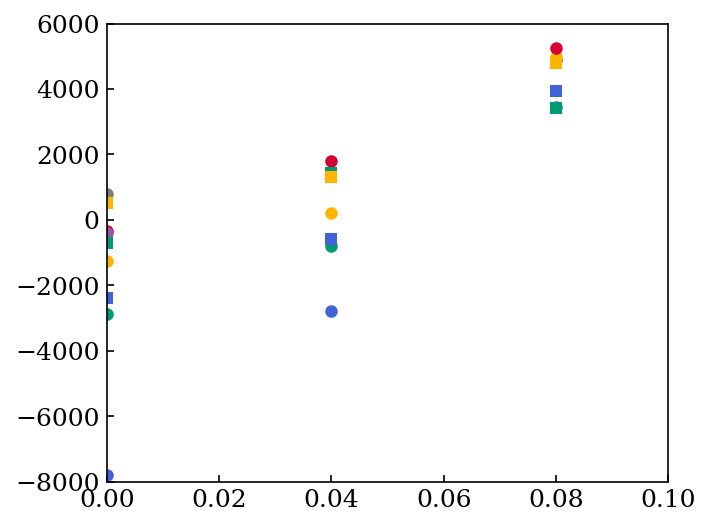

In [50]:
plt.clf()
# Plot the non-blocky PMF
_alpha = alpha[blocky]
_B = B[blocky]
_chrg = charge[blocky]
ualpha = np.unique(_alpha)
for a in ualpha:
    plt.plot(_chrg[_alpha == a]/50, _B[_alpha == a], 'o')

# Reset color wheel
plt.gca().set_prop_cycle(None)

# Plot the blocky PMF as squares
_alpha = alpha[~blocky]
_B = B[~blocky]
_chrg = charge[~blocky]
ualpha = np.unique(_alpha)
for a in ualpha:
    plt.plot(_chrg[_alpha == a]/50, _B[_alpha == a], 's')

plt.ylim(-8000,6000)
plt.xlim(0,0.1)

In [ ]:
[ 1,
  1, 1,
 -1,-1,
  1, 1,
 -1,-1,
  1, 1,
 -1,-1,
  1, 1,
 -1,-1,
  1, 1,
 -1,-1,
  1, 1,
 -1,-1,
  1, 1,
 -1,-1,
  1, 1,
 -1,-1,
  1, 1,
 -1,-1,
  1, 1,
 -1,-1,
  1, 1,
 -1,-1,
  1, 1,
 -1,-1,
 -1]

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

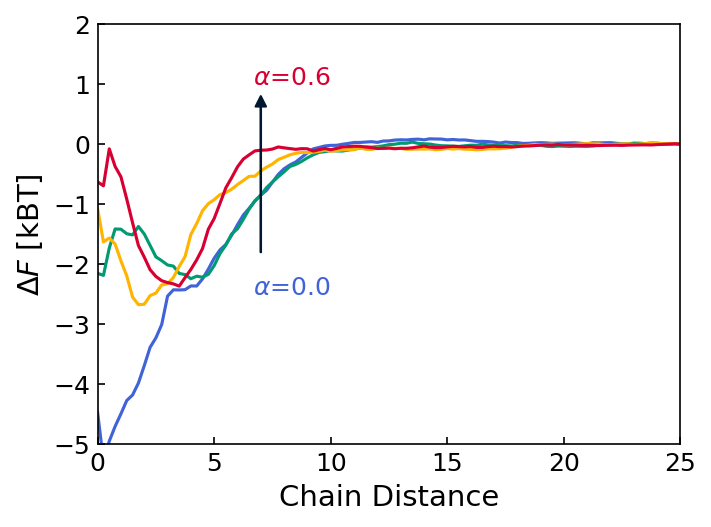

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.0ALPHA', '0.2ALPHA', '0.4ALPHA', '0.6ALPHA']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_0_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_neutral')

# Add labels and legend
# Move the annotation slightly to the left
# plt.annotate('', xy=(16.5, 2.5), xytext=(16.5, -0.5), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
# plt.text(15, 3, r'$Z_\mathrm{net}$', ha='left')

plt.annotate('', xy=(7, 0.8), xytext=(7,-1.8), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
plt.text(6.65, 1, r'$\alpha$=0.6', ha='left', color='#D80032')
plt.text(6.65, -2.5, r'$\alpha$=0.0', ha='left', color='#4063D8')

plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
# plt.legend()
plt.xlim(0, 25)
plt.ylim(-5,2)
# Show the plot
# plt.show()
plt.savefig('Rg_plot.png')
plt.savefig('Rg_plot.pdf')


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

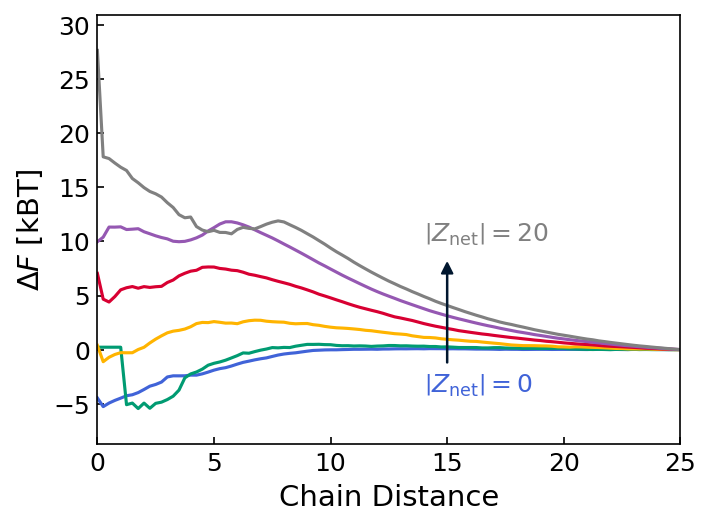

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.0ALPHA']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_0_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_neutral')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_4_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_4')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_8_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_8')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_12_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_12')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_16_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_16')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_20_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_20')

# Add labels and legend
# Move the annotation slightly to the left
# plt.annotate('', xy=(16.5, 2.5), xytext=(16.5, -0.5), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
# plt.text(15, 3, r'$Z_\mathrm{net}$', ha='left')

plt.annotate('', xy=(15, 8), xytext=(15,-1.2), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
plt.text(14, 10,r'$\left| Z_\mathrm{net} \right|=20$', ha='left', color = '#808080')

plt.text(14, -4, r'$\left| Z_\mathrm{net} \right|=0$', ha='left', color = '#4063D8')

plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
# plt.legend()
plt.xlim(0, 25)
# plt.ylim(-5,5)
# Show the plot
# plt.show()
plt.savefig('Rg_plot.png')
plt.savefig('Rg_plot.pdf')


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

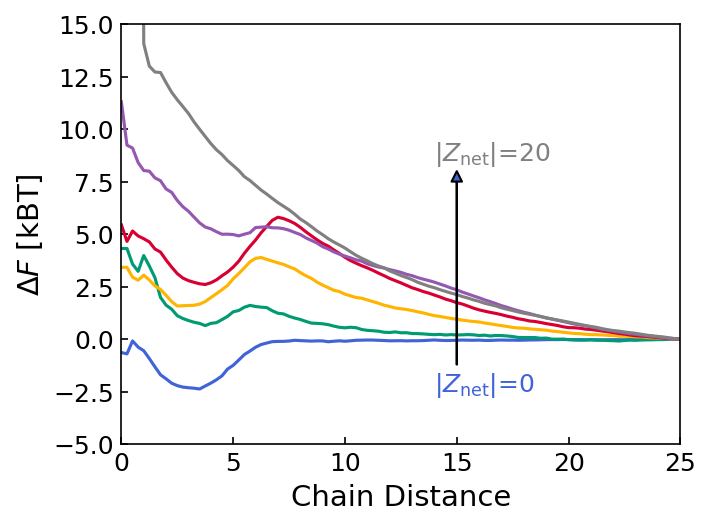

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.6ALPHA']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_0_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_neutral')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_4_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_4')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_8_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_8')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_12_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_12')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_16_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_16')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_20_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_20')

# Add labels and legend
# Move the annotation slightly to the left
# plt.annotate('', xy=(16.5, 2.5), xytext=(16.5, -0.5), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
# plt.text(15, 3, r'$Z_\mathrm{net}$', ha='left')

plt.annotate('', xy=(15, 8), xytext=(15,-1.2), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2})

# Move the text slightly to the left
plt.text(14, 8.5, r'|$Z_\mathrm{net}$|=20', ha='left', color = '#808080')

plt.text(14, -2.5, r'|$Z_\mathrm{net}$|=0', ha='left', color = '#4063D8')

plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
# plt.legend()
plt.xlim(0, 25)
plt.ylim(-5,15)
# Show the plot
# plt.show()

plt.savefig('Rg_plot.png')
plt.savefig('Rg_plot.pdf')


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

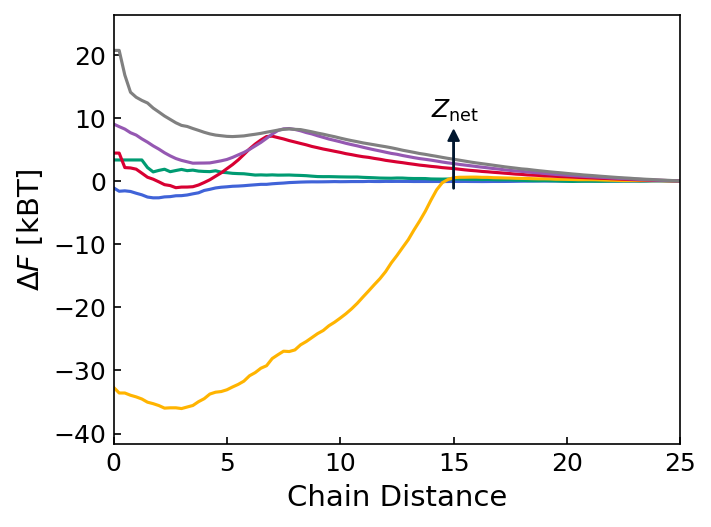

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.4ALPHA']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_0_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_neutral')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_4_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_4')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_8_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_8')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_12_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_12')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_16_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_16')

for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_20_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_20')

# Add labels and legend
# Move the annotation slightly to the left
# plt.annotate('', xy=(16.5, 2.5), xytext=(16.5, -0.5), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
# plt.text(15, 3, r'$Z_\mathrm{net}$', ha='left')

plt.annotate('', xy=(15, 8), xytext=(15,-1.2), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
plt.text(14, 10, r'$Z_\mathrm{net}$', ha='left')

plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
# plt.legend()
plt.xlim(0, 25)
# plt.ylim(-5,5)
# Show the plot
plt.show()


# Load Data

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

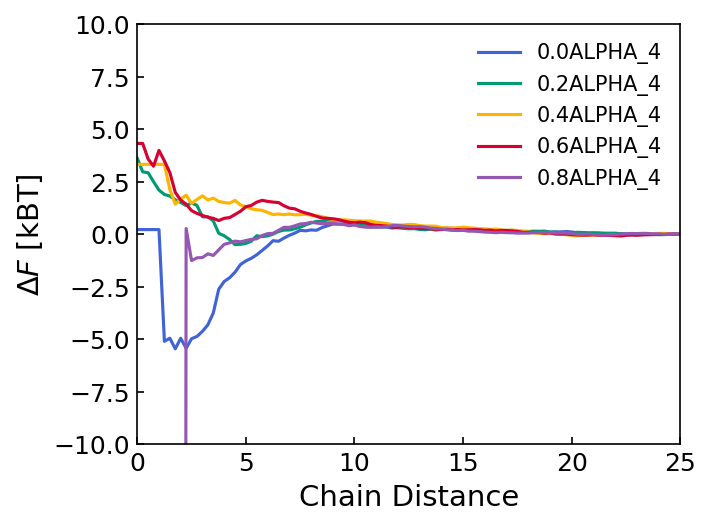

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.0ALPHA', '0.2ALPHA', '0.4ALPHA', '0.6ALPHA', '0.8ALPHA']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_4_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_4')

# Add labels and legend
# Move the annotation slightly to the left
# plt.annotate('', xy=(16.5, 2.5), xytext=(16.5, -0.5), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
# plt.text(15, 3, r'$Z_\mathrm{net}$', ha='left')

plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0, 25)
plt.ylim(-10,10)
# Show the plot
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

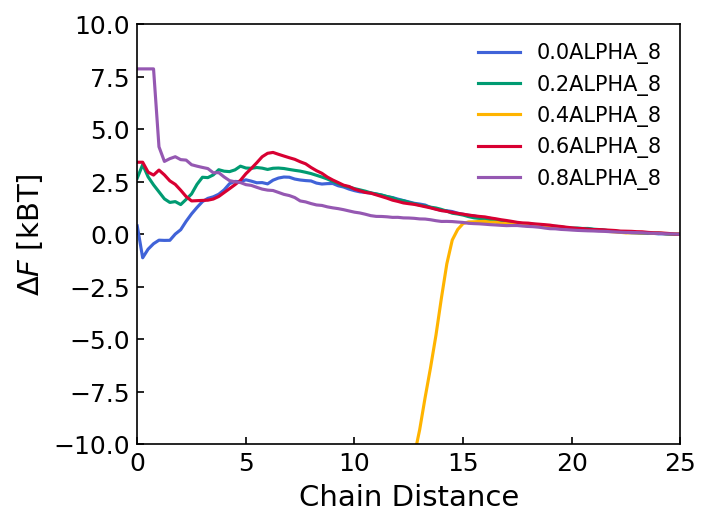

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.0ALPHA', '0.2ALPHA', '0.4ALPHA', '0.6ALPHA', '0.8ALPHA']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_8_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_8')

# Add labels and legend
# Move the annotation slightly to the left
# plt.annotate('', xy=(16.5, 2.5), xytext=(16.5, -0.5), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
# plt.text(15, 3, r'$Z_\mathrm{net}$', ha='left')

plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0, 25)
plt.ylim(-10,10)
# Show the plot
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

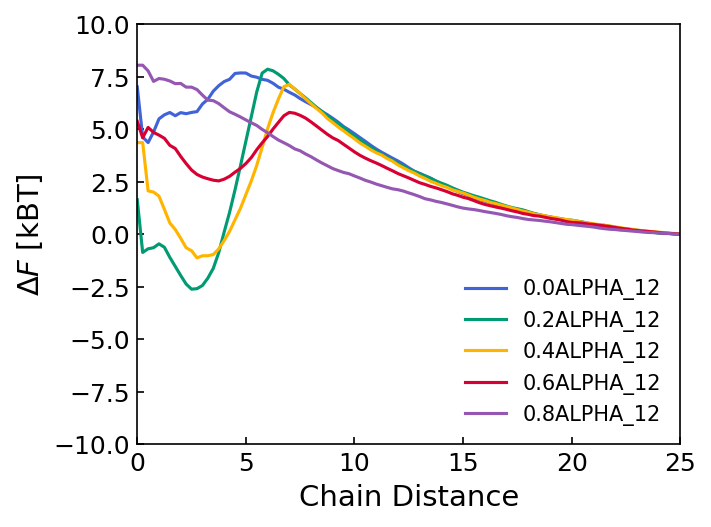

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.0ALPHA', '0.2ALPHA', '0.4ALPHA', '0.6ALPHA', '0.8ALPHA']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_12_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_12')

# Add labels and legend
# Move the annotation slightly to the left
# plt.annotate('', xy=(16.5, 2.5), xytext=(16.5, -0.5), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
# plt.text(15, 3, r'$Z_\mathrm{net}$', ha='left')

plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0, 25)
plt.ylim(-10,10)
# Show the plot
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

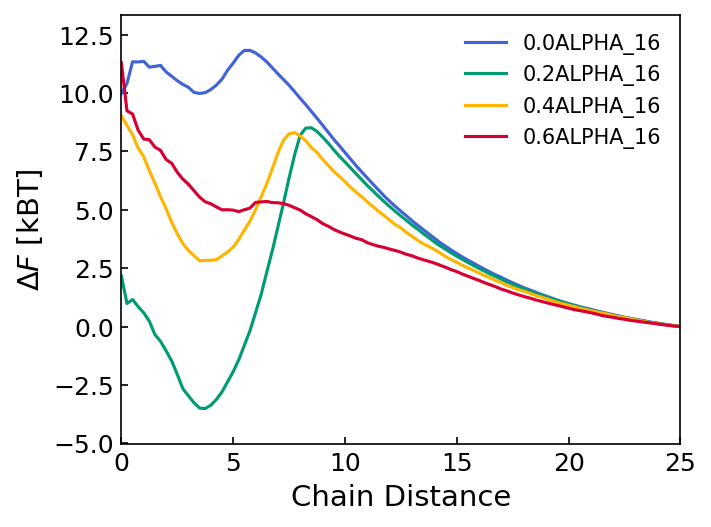

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.0ALPHA', '0.2ALPHA', '0.4ALPHA', '0.6ALPHA']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_16_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_16')

# Add labels and legend
# Move the annotation slightly to the left
# plt.annotate('', xy=(16.5, 2.5), xytext=(16.5, -0.5), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
# plt.text(15, 3, r'$Z_\mathrm{net}$', ha='left')

plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0, 25)
# plt.ylim(-10,10)
# Show the plot
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

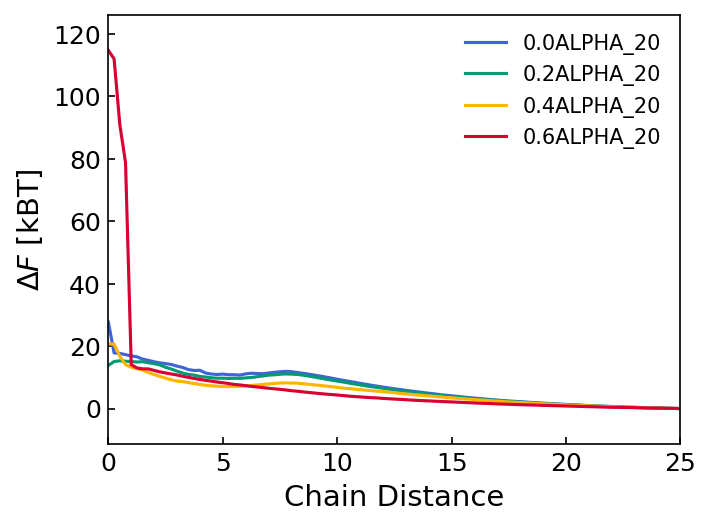

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.0ALPHA', '0.2ALPHA', '0.4ALPHA', '0.6ALPHA']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_nchain_2_znet_20_nsalt_0_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_20')

# Add labels and legend
# Move the annotation slightly to the left
# plt.annotate('', xy=(16.5, 2.5), xytext=(16.5, -0.5), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
# plt.text(15, 3, r'$Z_\mathrm{net}$', ha='left')

plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0, 25)
# plt.ylim(-10,10)
# Show the plot
plt.show()


In [11]:
import numpy as np
import matplotlib.pyplot as plt
 
# Define the sequences
sequences = ['RAND', 'ABAB', 'AABB', 'NEWGRAD']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_N_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=seq)

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


FileNotFoundError: ../data/poly_sequ_RAND_N_2_nchain_2_temp_1_pmf/prod.pmf not found.

<Figure size 735.236x551.427 with 0 Axes>

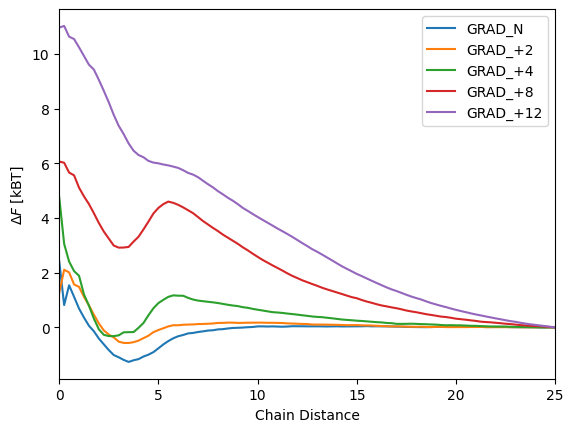

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = [ "GRAD"]

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_N_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')

    tag = f'poly_sequ_{seq}_N_+2_2_nchain_2_temp_1_pmf'

    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_N_+4_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    tag = f'poly_sequ_{seq}_N_+8_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+8')

    tag = f'poly_sequ_{seq}_N_+12_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+12')

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

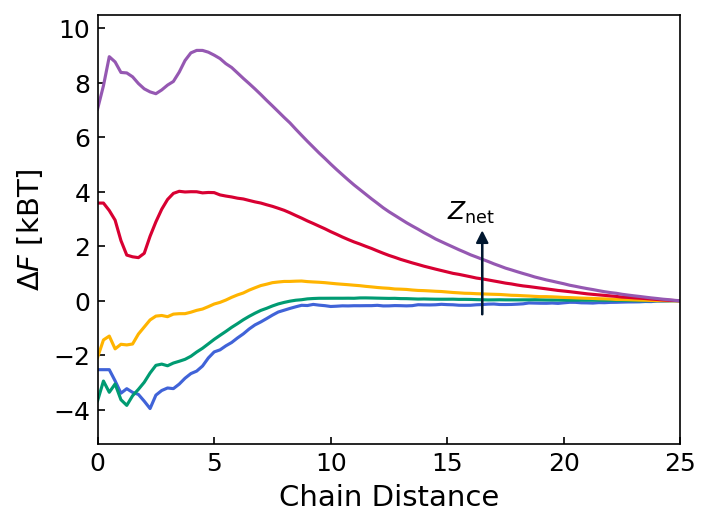

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['AABB']

# Initialize the plot
plt.clf()

# Plot data for each sequence



for seq in sequences:
    
    tag = f'poly_sequ_{seq}_N_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=r'0.0alpha_N')


    tag = f'poly_sequ_{seq}_N_+2_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'0.0alpha_+2')

    tag = f'poly_sequ_{seq}_N_+4_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'0.0alpha_+4')

    tag = f'poly_sequ_{seq}_N_+8_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'0.0alpha_+8')

    tag = f'poly_sequ_{seq}_N_+12_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'0.0alpha_+12')

# Add labels and legend
# Move the annotation slightly to the left
plt.annotate('', xy=(16.5, 2.5), xytext=(16.5,-0.5), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text slightly to the left
plt.text(15, 3, r'$Z_\mathrm{net}$', ha='left')


plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
# plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


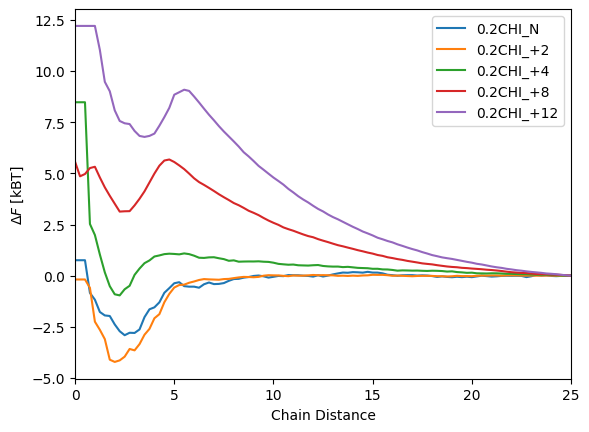

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.2CHI']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')
    
    tag = f'poly_sequ_{seq}_+2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_+4_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    tag = f'poly_sequ_{seq}_+8_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+8')

    tag = f'poly_sequ_{seq}_+12_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+12')
    

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


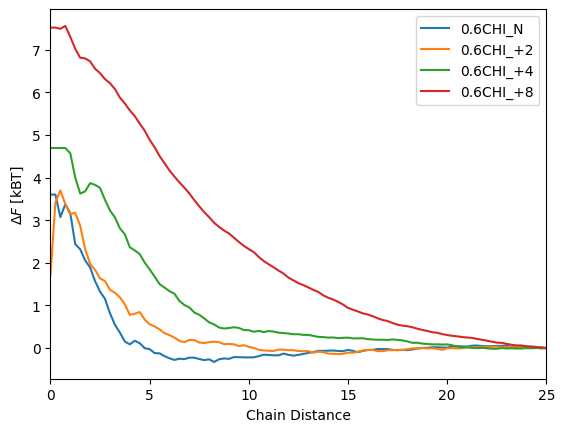

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.6CHI']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')
    
    tag = f'poly_sequ_{seq}_+2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_+4_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    tag = f'poly_sequ_{seq}_+8_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+8')

    # tag = f'poly_sequ_{seq}_+12_2_nchain_2_temp_1_pmf'
    # data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    # plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+12')

    

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


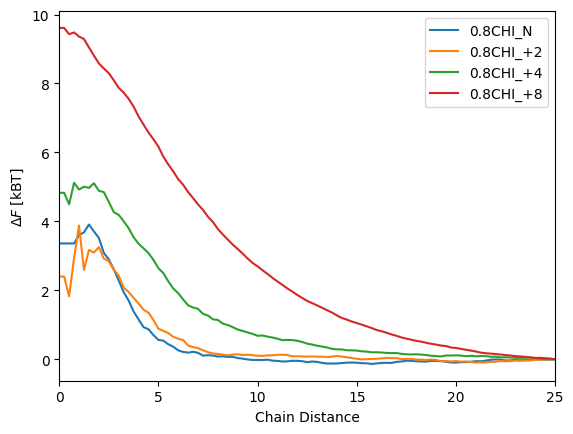

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.8CHI']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')
    
    tag = f'poly_sequ_{seq}_+2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_+4_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    tag = f'poly_sequ_{seq}_+8_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+8')

    

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


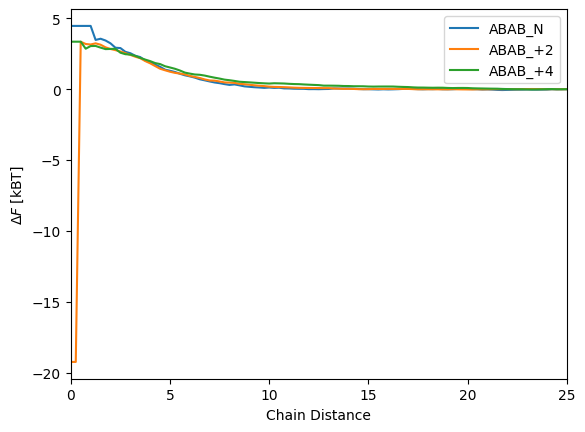

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['ABAB']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_N_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')
    
    tag = f'poly_sequ_{seq}_N_+2_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_N_+4_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

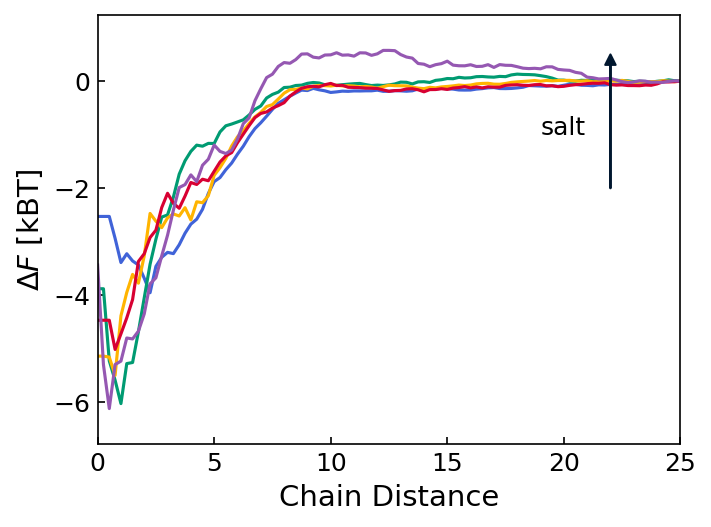

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['AABB']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_N_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'0.0alpha_N')


    tag = f'poly_sequ_{seq}_N_2_0.5_nchain_2_nsalt_40_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'0.0alpha_N_0.5')

    tag = f'poly_sequ_{seq}_N_2_nchain_2_nsalt_8_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'0.0alpha_N_0.1')

    tag = f'poly_sequ_{seq}_N_2_1.0_nchain_2_nsalt_80_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'0.0alpha_N_1.0')

    tag = f'poly_sequ_{seq}_N_2_2.0_nchain_2_nsalt_160_temp_1_pmf'
    data = np.loadtxt(f'../data/archive/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'0.0alpha_N_2.0')

# Add labels and legend
# Move the annotation to the right and down
plt.annotate('', xy=(22, 0.5), xytext=(22, -2), arrowprops={'headwidth': 5, 'headlength': 5, 'width': 0.2, 'color': '#01172F'})

# Move the text to the right and down
plt.text(19, -1.0, 'salt', ha='left')


# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
# plt.legend()
plt.xlim(0,25)

# Show the plot
# plt.show()
plt.savefig('Rg_plot.png')
plt.savefig('Rg_plot.pdf')



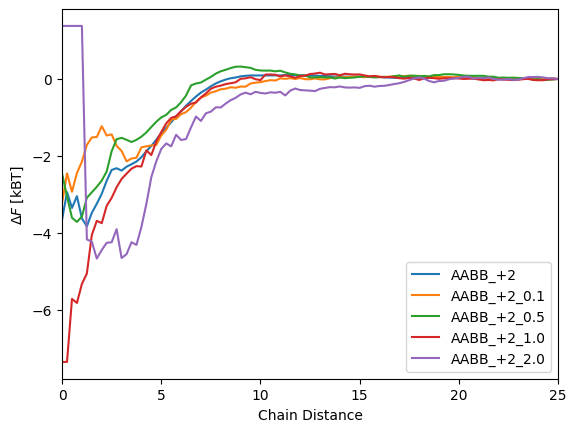

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['AABB']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_N_+2_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_N_+2_2_salt0.1_nchain_2_nsalt_8_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2_0.1')

    tag = f'poly_sequ_{seq}_N_+2_2_salt0.5_nchain_2_nsalt_40_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2_0.5')

    tag = f'poly_sequ_{seq}_N_+2_2_salt1.0_nchain_2_nsalt_80_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2_1.0')

    tag = f'poly_sequ_{seq}_N_+2_2_salt2.0_nchain_2_nsalt_160_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2_2.0')
    

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


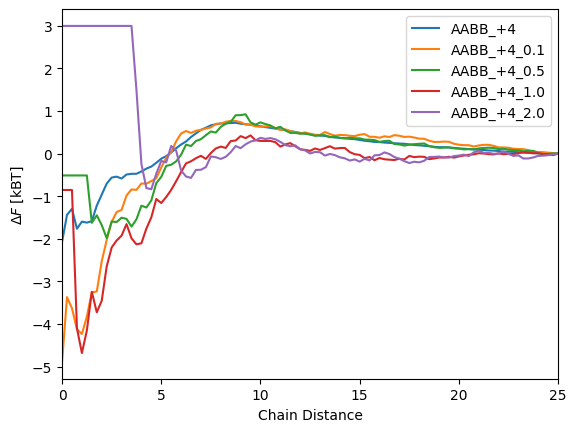

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['AABB']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_N_+4_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    tag = f'poly_sequ_{seq}_N_+4_2_salt_0.1_nchain_2_nsalt_8_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4_0.1')

    tag = f'poly_sequ_{seq}_N_+4_2_salt_0.5_nchain_2_nsalt_40_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4_0.5')

    tag = f'poly_sequ_{seq}_N_+4_2_salt_1.0_nchain_2_nsalt_80_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4_1.0')

    tag = f'poly_sequ_{seq}_N_+4_2_salt_2.0_nchain_2_nsalt_160_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4_2.0')
    

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


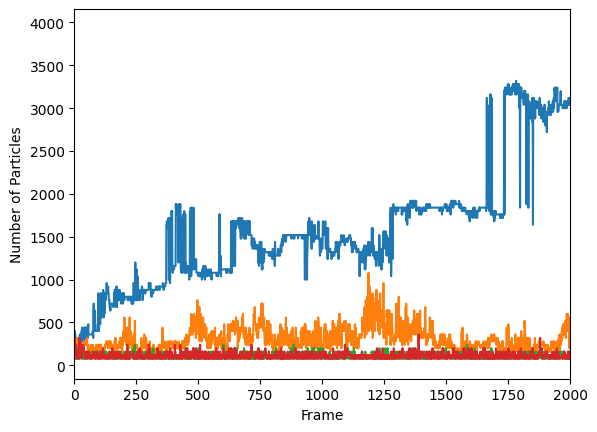

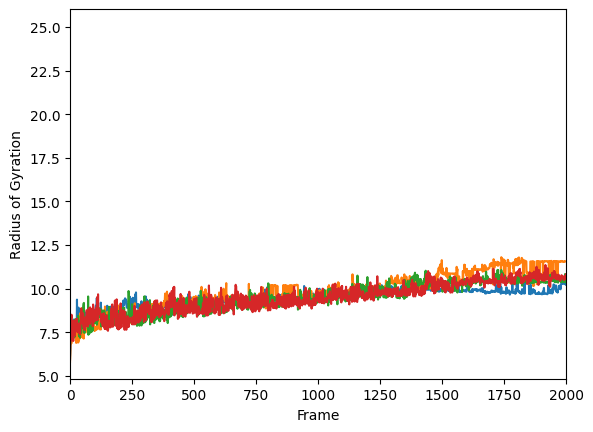

In [4]:

# Define the sequences
sequences = ['AABB','GRAD', 'ABAB','RAND']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_N_nchain_100_temp_1'
    data = np.loadtxt(f'../data/{tag}/cluster_size.txt', skiprows=1, usecols=[1,2])
    plt.plot(data[:,0], label=f'{seq}_cluster')

# Plot the data
plt.xlabel('Frame')
plt.ylabel('Number of Particles')
plt.xlim(0,2000)
plt.show()


# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_N_nchain_100_temp_1'
    data = np.loadtxt(f'../data/{tag}/cluster_size.txt', skiprows=1, usecols=[1,2])
    plt.plot(np.sqrt(data[:,1]), label=f'{seq}_cluster')

# Plot the data
plt.xlabel('Frame')
plt.ylabel('Radius of Gyration')
plt.xlim(0,2000)
plt.show()

# Radius of Gyration

In [269]:
gyr = Gyradius(ag,n_chains=100,n_monomers=40, unwrap=True)

In [270]:
gyr.run(start=1000)

100%|██████████| 2001/2001 [00:00<00:00, 6312.60it/s]


In [271]:
np.savetxt('../data/'+tag+'/gyr.txt',gyr.results.gyradii)

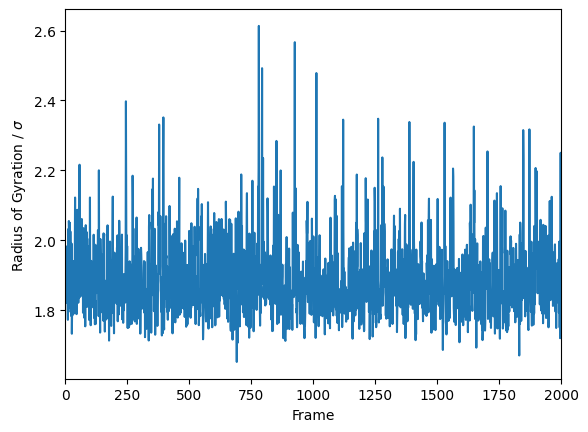

In [272]:
plt.plot(gyr.results.gyradii[0])
plt.xlabel('Frame')
plt.ylabel(f'Radius of Gyration / $\sigma$')
plt.xlim(0,2000)
plt.savefig('../data/'+tag+'/gyr.pdf')

# End-to-end Vector

In [273]:
e2e = EndToEndVector(ag,n_chains=1,n_monomers=40, unwrap=True)

/home/kfu/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [274]:
e2e.run(start=1000)
e2e.save('../data/'+tag+'/e2e')

/home/kfu/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/LAMMPS.py:598: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt
100%|██████████| 2001/2001 [00:00<00:00, 8074.74it/s]
1it [00:00, 2693.84it/s]


In [275]:
abs_e2e = np.zeros(len(e2e._e2e))

for i in range(len(e2e._e2e)):
    abs_e2e[i] = np.linalg.norm(e2e._e2e[i])

abs_e2e

array([2.23543372, 1.07988825, 1.16543384, ..., 3.27568639, 4.67249535,
       2.97711096])

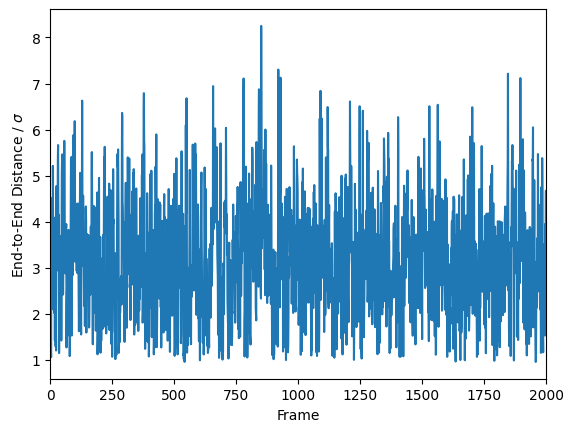

In [276]:
plt.plot(e2e.results.times,abs_e2e)
plt.xlabel('Frame')
plt.ylabel('End-to-End Distance / $\sigma$')
plt.xlim(0,2000)
plt.savefig('../data/'+tag+'/e2e.pdf')

/tmp/ipykernel_3005737/900919511.py:4: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,3000)


(0.6838305520458344, 3000)

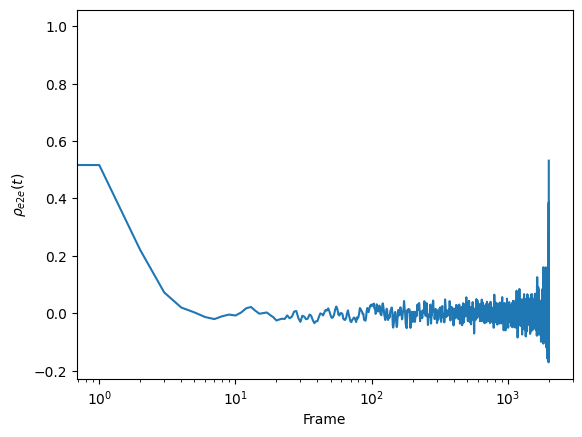

In [277]:
plt.semilogx(e2e.results.times,e2e.results.acf[0][0])
plt.xlabel('Frame')
plt.ylabel(r'$ \rho_{e2e}(t)$')   
plt.xlim(0,3000)

In [26]:
N = 1000
seq = np.ones(N)
seq[0:N//2] = -1
# SCD = sum_i^N sum_{i<j}^N seq_i*seq_j*sqrt(j-i)
SCD = 0
for i in range(N):
    for j in range(i+1, N):
        SCD += seq[i] * seq[j] * np.sqrt(np.abs(j-i))
SCD/N

np.float64(-2470.1051152132286)

In [28]:
N = 10000
seq = np.ones(N)
seq[::2] = -1
# SCD = sum_i^N sum_{i<j}^N seq_i*seq_j*sqrt(j-i)
SCD = 0
for i in range(N):
    for j in range(i+1, N):
        SCD += seq[i] * seq[j] * np.sqrt(j-i)
SCD/N

KeyboardInterrupt: 